In [1]:
import os, sys
import numpy as np
import pandas as pd
import geopandas as gpd
#from weather_funcs import *

stac vs gee EVI 2019-2022: PearsonRResult(statistic=0.9459744669626146, pvalue=3.901192077006303e-24)


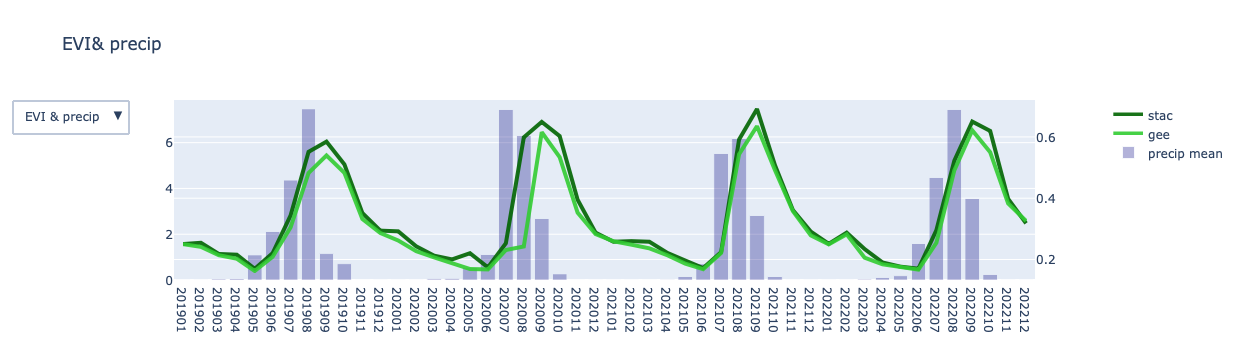

precip vs gee EVI 2019-2022: PearsonRResult(statistic=0.29786970579373506, pvalue=0.03975961532949099)
precip vs stac EVI 2019-2022: PearsonRResult(statistic=0.40633934657005044, pvalue=0.004159916223830228)
gee 1month lag: PearsonRResult(statistic=0.7722618711569424, pvalue=2.0572471548384935e-10)
stac 1month lag: PearsonRResult(statistic=0.874950301686128, pvalue=9.011138052656375e-16)


In [167]:
## corr coeff for STAC vs GEE time series 

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
import pandas as pd
from scipy.stats import pearsonr   

commonStartYR=2019
commonEndYR=2022
VI="EVI"
stacFi=r"C:\Users\Lauren\Downloads\fieldPts_stac"+VI+"1822.csv"
geeFi=r"C:\Users\Lauren\Downloads\fieldPts_gee"+VI+"1923.csv"

df1 = pd.read_csv(stacFi, index_col=["Unnamed: 0", "geometry"])
df1.columns = [i.split("_")[-1] for i in df1.columns.to_list() ]
df1 = df1[[i for i in df1.columns.to_list() if int(i[:4]) >= commonStartYR and int(i[:4]) <= commonEndYR]]
for col in df1.columns.to_list(): 
    df1[col] = df1[col].mask(df1[col] >= 1, 1)
    df1[col] = df1[col].mask(df1[col] <= -1, -1)
stac_means =[df1[i].values[~np.isnan(df1[i].values)].mean() for i in df1.columns.to_list()]

df2 = pd.read_csv(geeFi, index_col=["Unnamed: 0", "geometry"])
df2.columns = [i.split("_")[-1] for i in df2.columns.to_list() ]
df2 = df2[[i for i in df2.columns.to_list() if int(i[:4]) >= commonStartYR and int(i[:4]) <= commonEndYR]]
if VI=="EVI":
    for col in df2.columns.to_list():
        df2[col] = df2[col].mask(df2[col] >= 10000, 10000)
        df2[col] = df2[col].mask(df2[col] <= 0, 0)
elif VI=="NDMI1":
    for col in df2.columns.to_list(): 
        df2[col] = df2[col].mask(df2[col] >= 1000, 1000)
        df2[col] = df2[col].mask(df2[col] <= -2000, -2000)        
        
gee_means = [i/10000 for i in df2.mean().to_list()]

VI_dates = df2.columns.to_list()

print('stac vs gee '+VI+' '+str(commonStartYR)+'-'+str(commonEndYR)+':',  pearsonr(stac_means, gee_means))

### step 3: PLOT TIME SERIES

out_dir = r"C:\Users\Lauren\Documents\01_Demilunes"
CLIfi=r"C:\Users\Lauren\Desktop\village_climate.csv"
tempVars = ["max", "mean", "min"]
opacities=[0.3, 0.7, 0.3]
Twidths = [1,2,1]

colors = {'stac':'darkgreen',
          'gee': 'limegreen', 
          'precip': 'navy',
          'Tmin': 'chocolate',
          'Tmax': 'firebrick',
         }

Cdf = pd.read_csv(CLIfi, index_col=["Unnamed: 0", "villID", "treated"])
Pdf = Cdf[[i for i in Cdf.columns.to_list() if i.startswith("precip") and i.endswith("mean")]]
Pdf.columns = [i.split("_")[1] for i in Pdf.columns.to_list() ]
Pdf = Pdf[[i for i in Pdf.columns.to_list() if int(i[:4]) >= commonStartYR and int(i[:4]) <= commonEndYR]]
PrecipMean =[Pdf[i].values[~np.isnan(Pdf[i].values)].mean() for i in Pdf.columns.to_list()]

HighTemps = []
LowTemps = []
for tempVar in tempVars:
    Tdf = Cdf[[i for i in Cdf.columns.to_list() if i.startswith("Tmax") and i.endswith(tempVar)]]
    Tdf.columns = [i.split("_")[1] for i in Tdf.columns.to_list() ]
    Tdf = Tdf[[i for i in Tdf.columns.to_list() if int(i[:4]) >= commonStartYR and int(i[:4]) <= commonEndYR]]
    TempStatMax =[Tdf[i].values[~np.isnan(Tdf[i].values)].mean() for i in Tdf.columns.to_list()]
    HighTemps.append(TempStatMax)

    TdfMin = Cdf[[i for i in Cdf.columns.to_list() if i.startswith("Tmin") and i.endswith(tempVar)]]
    TdfMin.columns = [i.split("_")[1] for i in TdfMin.columns.to_list() ]
    TdfMin = TdfMin[[i for i in TdfMin.columns.to_list() if int(i[:4]) >= commonStartYR and int(i[:4]) <= commonEndYR]]
    TempStatMin =[TdfMin[i].values[~np.isnan(TdfMin[i].values)].mean() for i in TdfMin.columns.to_list()]
    LowTemps.append(TempStatMin)
    
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace( go.Scatter(x=VI_dates, y=stac_means, line={'width': 4}, opacity=0.9, name="stac", marker_color=colors['stac']), secondary_y=True )
fig.add_trace( go.Scatter(x=VI_dates, y=gee_means, line={'width': 4}, opacity=0.9, name="gee", marker_color=colors['gee']), secondary_y=True )
fig.add_trace( go.Bar(x=VI_dates, y=PrecipMean, opacity=0.3, name="precip mean", marker_color=colors['precip']), secondary_y=False ) 

# ## temps (min-mean-max) stacked bar chart
c=0
for h, l in list(zip(HighTemps, LowTemps)):
    fig.add_trace( go.Scatter(
        name = tempVars[c]+" HighTemp",
        line={'width':Twidths[c]},
         x=VI_dates, y=h,  
         offsetgroup=1,
        opacity=opacities[c], marker_color=colors['Tmax']
     ),  secondary_y=False   )
    fig.add_trace( go.Scatter(
        name = tempVars[c]+" LowTemp",
        line={'width':Twidths[c]},
         x=VI_dates, y=l,  
         offsetgroup=1,
        opacity=opacities[c], marker_color=colors['Tmin']
     ),  secondary_y=False   )
    c+=1

fig.update_layout(
    updatemenus=[dict( active=0, buttons=list(  [    
        
             dict(label = "ALL",
                  method = 'update',
                  args = [{'visible': [True, True, True, True, True, True, True, True, True]}, 
                          {'title': 'stac and gee EVI w/ precip & temps',
                           'showlegend':True}]),
        
             dict(label = VI+" & precip",
                  method = 'update',
                  args = [{'visible': [True, True, True, False, False, False, False, False, False]}, 
                          {'title':  VI+ "& precip",
                           'showlegend':True}]),

             dict(label = VI+" & temps",
                  method = 'update',
                  args = [{'visible':[True, True, False, True, True, True, True, True, True]}, 
                          {'title':  VI+" & temps",
                           'showlegend':True}]),
            ]) ) ])
    
fig.update_layout(title_text="stac and gee "+VI+" w/ precip & temps")
fig.show()
fig.write_html(os.path.join(out_dir, "stac_vs_gee_"+VI+".html"))

print('precip vs gee '+VI+' '+str(commonStartYR)+'-'+str(commonEndYR)+':',  pearsonr(PrecipMean, gee_means))
print('precip vs stac '+VI+' '+str(commonStartYR)+'-'+str(commonEndYR)+':',  pearsonr(PrecipMean, stac_means))

## one month lag
PrecipMean.insert(0, 0)
print('gee 1month lag:', pearsonr(PrecipMean[1:-1], gee_means[1:]))
print('stac 1month lag:', pearsonr(PrecipMean[1:-1], stac_means[1:]))


In [171]:
climeans = HighTemps[1] ## mean [1:]

print('high temp mean vs gee '+VI+' '+str(commonStartYR)+'-'+str(commonEndYR)+':',  pearsonr(climeans, gee_means))
print('high temp mean vs stac '+VI+' '+str(commonStartYR)+'-'+str(commonEndYR)+':',  pearsonr(climeans, stac_means))

## one month lag
climeans.insert(0, 0)
print('gee 1month lag:', pearsonr(climeans[1:-1], gee_means[1:]))
print('stac 1month lag:', pearsonr(climeans[1:-1], stac_means[1:]))

high temp mean vs gee EVI 2019-2022: PearsonRResult(statistic=-0.3507406705331727, pvalue=0.014519448863067216)
high temp mean vs stac EVI 2019-2022: PearsonRResult(statistic=-0.3792963079412929, pvalue=0.007843533246008587)
gee 1month lag: PearsonRResult(statistic=-0.47572631794624326, pvalue=0.0007258862729611058)
stac 1month lag: PearsonRResult(statistic=-0.4701754776835192, pvalue=0.0008537279106237388)


In [172]:
climeans = HighTemps[0] ## mean

print('high temp max vs gee '+VI+' '+str(commonStartYR)+'-'+str(commonEndYR)+':',  pearsonr(climeans, gee_means))
print('high temp max vs stac '+VI+' '+str(commonStartYR)+'-'+str(commonEndYR)+':',  pearsonr(climeans, stac_means))

## one month lag
climeans.insert(0, 0)
print('gee 1month lag:', pearsonr(climeans[1:-1], gee_means[1:]))
print('stac 1month lag:', pearsonr(climeans[1:-1], stac_means[1:]))

high temp max vs gee EVI 2019-2022: PearsonRResult(statistic=-0.5372023318078021, pvalue=8.256795361370212e-05)
high temp max vs stac EVI 2019-2022: PearsonRResult(statistic=-0.5688047082733679, pvalue=2.463556069877177e-05)
gee 1month lag: PearsonRResult(statistic=-0.5954043855150608, pvalue=1.0120068353731219e-05)
stac 1month lag: PearsonRResult(statistic=-0.5714045975986379, pvalue=2.7298809205946752e-05)


In [173]:
climeans = HighTemps[-1] ## mean

print('high temp min vs gee '+VI+' '+str(commonStartYR)+'-'+str(commonEndYR)+':',  pearsonr(climeans, gee_means))
print('high temp min vs stac '+VI+' '+str(commonStartYR)+'-'+str(commonEndYR)+':',  pearsonr(climeans, stac_means))

## one month lag
climeans.insert(0, 0)
print('gee 1month lag:', pearsonr(climeans[1:-1], gee_means[1:]))
print('stac 1month lag:', pearsonr(climeans[1:-1], stac_means[1:]))

high temp min vs gee EVI 2019-2022: PearsonRResult(statistic=-0.2797966599261166, pvalue=0.05409767323264922)
high temp min vs stac EVI 2019-2022: PearsonRResult(statistic=-0.287460793725039, pvalue=0.04757741338667823)
gee 1month lag: PearsonRResult(statistic=-0.40364379763292235, pvalue=0.0049001001986216635)
stac 1month lag: PearsonRResult(statistic=-0.39069358035097423, pvalue=0.0066239697786046724)


In [129]:
## corr coeff for 1 veg index and 1 temp var

from scipy.stats import pearsonr   

VIfi=r"C:\Users\Lauren\Desktop\FieldPts_NDMI1_1723.csv"
climateVar=["Tmax", "max"]

CLIfi=r"C:\Users\Lauren\Desktop\village_climate.csv"

df1 = pd.read_csv(CLIfi, index_col=["Unnamed: 0", "villID", "treated"])
df1 = df1[[i for i in df1.columns.to_list() if i.startswith(climateVar[0]) and i.endswith(climateVar[1])]]
df1.columns = [i.split("_")[1] for i in df1.columns.to_list() ]
df1 = df1[[i for i in df1.columns.to_list() if int(i[:4]) >= 2017 and int(i[:4]) < 2023]]
climate_means =[df1[i].values[~np.isnan(df1[i].values)].mean() for i in df1.columns.to_list()]

df2 = pd.read_csv(VIfi, index_col="Unnamed: 0")
for col in df2.columns.to_list(): 
    ##df[col] = df[col].where((df[col] <= 1) & (df[col] >= -1))    
    df2[col] = df2[col].mask(df2[col] > 1, 1)
    df2[col] = df2[col].mask(df2[col] < -1, -1)

VI_means = [df2[i].values[~np.isnan(df2[i].values)].mean() for i in df2.columns.to_list()]
print(climateVar, os.path.basename(VIfi), ':')
VI_means = [df2[i].values[~np.isnan(df2[i].values)].mean() for i in df2.columns.to_list()]
print('no lag:',  pearsonr(climate_means, VI_means))
## one month lag
climate_means.insert(0, 0)
print('one month lag:', pearsonr(climate_means[1:-1], VI_means[1:]))


['Tmax', 'max'] FieldPts_NDMI1_1723.csv :
no lag: PearsonRResult(statistic=-0.6040765726187409, pvalue=1.9322999073218686e-08)
one month lag: PearsonRResult(statistic=-0.5981014783851513, pvalue=3.632073082336777e-08)


In [127]:
## corr coeff for 1 veg index and 1 precip var 

from scipy.stats import pearsonr   

VIfi=r"C:\Users\Lauren\Desktop\FieldPts_EVI_1723.csv"
climateVar=["precip", "mean"]

CLIfi=r"C:\Users\Lauren\Desktop\village_climate.csv"

df1 = pd.read_csv(CLIfi, index_col=["Unnamed: 0", "villID", "treated"])
df1 = df1[[i for i in df1.columns.to_list() if i.startswith(climateVar[0]) and i.endswith(climateVar[1])]]
df1.columns = [i.split("_")[1] for i in df1.columns.to_list() ]
df1 = df1[[i for i in df1.columns.to_list() if int(i[:4]) >= 2017 and int(i[:4]) < 2023]]
climate_means =[df1[i].values[~np.isnan(df1[i].values)].mean() for i in df1.columns.to_list()]

df2 = pd.read_csv(VIfi, index_col="Unnamed: 0")
for col in df2.columns.to_list(): 
    ##df[col] = df[col].where((df[col] <= 1) & (df[col] >= -1))    
    df2[col] = df2[col].mask(df2[col] > 1, 1)
    df2[col] = df2[col].mask(df2[col] < -1, -1)
print(climateVar, os.path.basename(VIfi), ':')
VI_means = [df2[i].values[~np.isnan(df2[i].values)].mean() for i in df2.columns.to_list()]
print('no lag:',  pearsonr(climate_means, VI_means))
## one month lag
climate_means.insert(0, 0)
print('one month lag:', pearsonr(climate_means[1:-1], VI_means[1:]))


['precip', 'mean'] FieldPts_EVI_1723.csv :
no lag: PearsonRResult(statistic=0.43152895650234646, pvalue=0.0001539364806458885)
one month lag: PearsonRResult(statistic=0.8778448059838937, pvalue=9.450243841148035e-24)


In [79]:
## corr coeff for 1 veg index and 1 climate var 

from scipy.stats import pearsonr   

VIfi=r"C:\Users\Lauren\Desktop\FieldPts_NDMI2_1723.csv"
climateVar=["Tmax", "mean"]

CLIfi=r"C:\Users\Lauren\Desktop\village_climate.csv"

df1 = pd.read_csv(CLIfi, index_col=["Unnamed: 0", "villID", "treated"])
df1 = df1[[i for i in df1.columns.to_list() if i.startswith(climateVar[0]) and i.endswith(climateVar[1])]]
df1.columns = [i.split("_")[1] for i in df1.columns.to_list() ]
df1 = df1[[i for i in df1.columns.to_list() if int(i[:4]) >= 2017 and int(i[:4]) < 2023]]
climate_means =[df1[i].values[~np.isnan(df1[i].values)].mean() for i in df1.columns.to_list()]

df2 = pd.read_csv(VIfi, index_col="Unnamed: 0")
for col in df2.columns.to_list(): 
    ##df[col] = df[col].where((df[col] <= 1) & (df[col] >= -1))    
    df2[col] = df2[col].mask(df2[col] > 1, 1)
    df2[col] = df2[col].mask(df2[col] < -1, -1)

VI_means = [df2[i].values[~np.isnan(df2[i].values)].mean() for i in df2.columns.to_list()]

print(pearsonr(climate_means, VI_means))

PearsonRResult(statistic=-0.4419436213694481, pvalue=0.00010169684633734916)


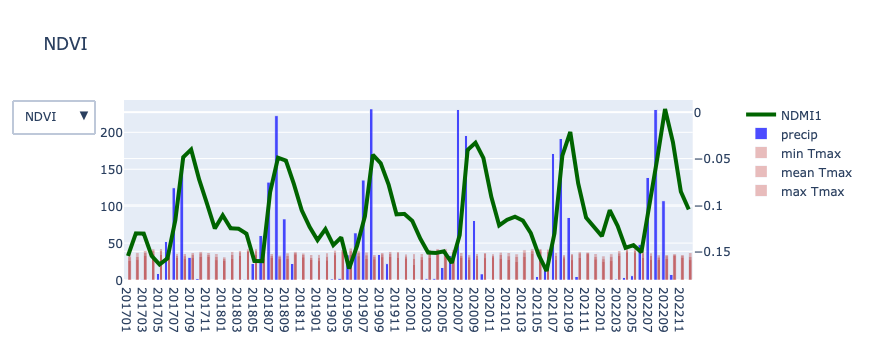

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
import pandas as pd
temp_var = "Tmax"
out_dir = r"C:\Users\Lauren\Documents\01_Demilunes"


# ## read VIs
VI_MonMeans = []
VIs=[]
for file in [r"C:\Users\Lauren\Desktop\FieldPts_NDMI1_1723.csv",
           r"C:\Users\Lauren\Desktop\FieldPts_NDMI2_1723.csv",
           r"C:\Users\Lauren\Desktop\FieldPts_NDVI_1723.csv",
             r"C:\Users\Lauren\Desktop\FieldPts_EVI_1723.csv",
             r"C:\Users\Lauren\Desktop\FieldPts_NDWI_1723.csv"
            ]:
    df = pd.read_csv(file)
    VI_date_tmp = df.columns.to_list()
    VIs.append(os.path.basename(file).split("_")[1])
    ## reclass outliers to 1 or -1
    for col in df.columns.to_list(): 
        ##df[col] = df[col].where((df[col] <= 1) & (df[col] >= -1))    
        df[col] = df[col].mask(df[col] > 1, 1)
        df[col] = df[col].mask(df[col] < -1, -1)

    monthly_means = [df[i].values[~np.isnan(df[i].values)].mean() for i in df.columns.to_list()]
    VI_MonMeans.append(monthly_means)
    

vi_df_use = pd.DataFrame(VI_MonMeans, VIs, VI_date_tmp).iloc[:,1:].T
VI_dates = vi_df_use.index.to_list()
vi_df_use['NDWI'] = [-1*i for i in vi_df_use['NDWI']]

# vi_df = pd.read_csv(r"C:\Users\Lauren\Desktop\DL_field_TS_avg.csv", index_col=0)
# VI_dates = vi_df.columns.to_list()
# vi_df_use = vi_df.T

## read precip
climate_csv=r"C:\Users\Lauren\Desktop\village_climate_avgs.csv"
df = pd.read_csv(climate_csv)
Pdf = df[[i for i in df.columns.to_list() if (i.endswith("sum") and i.startswith("precip"))]]
Pdf.columns  = [i.replace("precip_", "").replace("_sum", "") for i in Pdf.columns.to_list() ] 
Pdf = Pdf[[i for i in Pdf.columns.to_list() if i in VI_dates]].iloc[0] ## .iloc[0] for mean, .iloc[1] for 90th percentile
precip_TS = Pdf.to_list()

## read temp
min_mean_max=[]
for stat in ["min", "mean", "max"]:
    Tdf = df[[i for i in df.columns.to_list() if (i.endswith(stat) and i.startswith(temp_var))]]
    Tdf.columns  = [i.replace(temp_var+"_", "").replace("_"+stat, "") for i in Tdf.columns.to_list() ] 
    Tdf = Tdf[[i for i in Tdf.columns.to_list() if i in VI_dates]].iloc[0] ## .iloc[0] for mean, .iloc[1] for 90th percentile
    min_mean_max.append(Tdf.to_list())
min_mean_maxs = list(zip(["min", "mean", "max"], min_mean_max))

colors = {'precip':'blue',
          'Tmin':'orangered',
          'Tmax':'firebrick',
          'NDVI': 'forestgreen', 
          'EVI': 'limegreen', 
          'NDMI1': 'darkgreen', 
          'NDMI2': 'mediumseagreen', 
          'NDWI': 'lime'
         }


fig = make_subplots(specs=[[{"secondary_y": True}]])

for column in vi_df_use.columns.to_list():
    fig.add_trace( go.Scatter(x=VI_dates, y=vi_df_use[column], line={'width': 4}, opacity=1.0, name=column, marker_color=colors[column]), secondary_y=True )

fig.add_trace( go.Bar(
     x=VI_dates, y=precip_TS,  
    offsetgroup=0,
    opacity=0.7, name="precip", marker_color=colors["precip"]
 ),  secondary_y=False   )

# ## temps (min-mean-max) stacked bar chart
for m in min_mean_maxs:
    fig.add_trace( go.Bar(
        name = m[0]+" "+temp_var,
         x=VI_dates, y=m[1],  
         offsetgroup=1,
        opacity=0.3, marker_color=colors[temp_var]
     ),  secondary_y=False   )
    # precip mean bar chart


fig.update_layout(
    updatemenus=[dict(
        active=0,
        buttons=list(
            [             
            dict(label = 'ALL',
                  method = 'update',
                  args = [{'visible': [True, True, True, True, True, True, True, True, True]}, # the index of True aligns with the indices of plot traces
                          {'title': 'ALL',
                           'showlegend':True}]),
             dict(label = 'NDVI',
                  method = 'update',
                  args = [{'visible': [True, False, False, False, False, True, True, True, True]}, 
                          {'title': 'NDVI',
                           'showlegend':True}]),
             dict(label = 'EVI',
                  method = 'update',
                  args = [{'visible': [False, True, False, False, False, True, True, True, True]}, 
                          {'title': 'EVI',
                           'showlegend':True}]),
             dict(label = 'NDMI1',
                  method = 'update',
                  args = [{'visible': [False, False, True, False, False, True, True, True, True]}, 
                          {'title': 'NDMI1',
                           'showlegend':True}]),  
             dict(label = 'NDMI2',
                  method = 'update',
                  args = [{'visible': [False, False, False, True, False, True, True, True, True]}, 
                          {'title': 'NDMI2',
                           'showlegend':True}]),                 
             dict(label = 'NDWI',
                  method = 'update',
                  args = [{'visible': [False, False, False, False, True, True, True, True, True]}, 
                          {'title': 'NDWI',
                           'showlegend':True}]), 
            ])
        )
    ])
    
    



fig.update_layout(title_text='village-'+temp_var.upper()+" field-VIs")

fig.show()

fig.write_html(os.path.join(out_dir, "village-PRECIPs_"+temp_var.upper()+"_field-VIs_revNDWI.html"))

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
import pandas as pd

VI="NDMI2"
climate_var = ["Tmin", "max"]
out_dir=r'C:\Users\Lauren\Desktop'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    
climate_csv=r"C:\Users\Lauren\Desktop\village_climate.csv"
Cdf = pd.read_csv(climate_csv)


vi_df = pd.read_csv(r'C:\Users\Lauren\Desktop\FieldPts_NDMI1_1723.csv')
VI_dates = vi_df.columns.to_list()[1:]
VI_TS = vi_df.mean(axis=0, skipna=True)[1:]

Cdf = Cdf[[i for i in Cdf.columns.to_list() if(i.startswith(climate_var[0]) and i.endswith(climate_var[-1])) ]]
Cdf.columns = [i.replace(climate_var[0]+"_", "").replace("_"+climate_var[-1], "") for i in Cdf.columns.to_list()]
Cdf =Cdf[[i for i in Cdf.columns.to_list() if i in VI_dates]]
climate_TS = Cdf.mean(axis=0, skipna=True)

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])
if "T" in climate_var[0]:
    fig.add_trace( go.Scatter(x=VI_dates, y=climate_TS,  name=climate_var[0]+"_"+climate_var[-1]),secondary_y=False )
elif "precip" in climate_var[0]:
    fig.add_trace( go.Bar(x=VI_dates, y=climate_TS, name=climate_var[0]+"_"+climate_var[-1]),  secondary_y=False )

fig.add_trace( go.Scatter(x=VI_dates, y=VI_TS, name=VI),  secondary_y=True )
fig.update_layout(  title_text="village climate: "+climate_var[0]+"_"+climate_var[-1]+" and "+VI)
fig.update_xaxes(title_text="month")
fig.update_yaxes(title_text="monthly "+climate_var[0]+"_"+climate_var[-1], secondary_y=False)
fig.update_yaxes(title_text="monthly "+VI, secondary_y=True)
fig.show()

fig.write_html(os.path.join(out_dir, "village"+climate_var[0].upper()+climate_var[-1]+"_field"+VI.upper()+".html"))

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
import pandas as pd
import numpy as np

#in_fi = r"C:\Users\Lauren\Desktop\fieldPts_stacMeanEVI1822.csv"
#df = pd.read_csv(in_fi, index_col=["Unnamed: 0", "geometry"])
##df = df.set_index(["Unnamed: 0", "geometry"])

## reclass outliers to 1 or -1
for col in df.columns.to_list():
    df[col] = df[col].where((df[col] <= 1) & (df[col] >= -1))

monthly_means = [df[i].values[~np.isnan(df[i].values)].mean() for i in df.columns.to_list()]
monthly_stds = [df[i].values[~np.isnan(df[i].values)].std() for i in df.columns.to_list()]
VI_dates = [i.split("_")[-1] for i in df.columns.to_list()]

fig = go.Figure(
    data=[go.Scatter(x=VI_dates, y=monthly_means)],
    layout=go.Layout(
        title=go.layout.Title(text="stac EVI mean")
    )
)

fig.show()



In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
import pandas as pd

VI="NDMI2"
climate_var = ["Tmin", "max"]
out_dir=r'C:\Users\Lauren\Desktop'

VI_csv=r'C:\Users\Lauren\Desktop\FieldPts_'+VI+'_1723.csv'
climate_csv=r"C:\Users\Lauren\Desktop\village_climate.csv"

if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    
vi_df = pd.read_csv(VI_csv)
VI_dates = vi_df.columns.to_list()[1:]
VI_TS = vi_df.mean(axis=0, skipna=True)[1:]

Cdf = pd.read_csv(climate_csv)
Cdf = Cdf[[i for i in Cdf.columns.to_list() if(i.startswith(climate_var[0]) and i.endswith(climate_var[-1])) ]]
Cdf.columns = [i.replace(climate_var[0]+"_", "").replace("_"+climate_var[-1], "") for i in Cdf.columns.to_list()]
Cdf =Cdf[[i for i in Cdf.columns.to_list() if i in VI_dates]]
climate_TS = Cdf.mean(axis=0, skipna=True)

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])
if "T" in climate_var[0]:
    fig.add_trace( go.Scatter(x=VI_dates, y=climate_TS,  name=climate_var[0]+"_"+climate_var[-1]),secondary_y=False )
elif "precip" in climate_var[0]:
    fig.add_trace( go.Bar(x=VI_dates, y=climate_TS, name=climate_var[0]+"_"+climate_var[-1]),  secondary_y=False )

fig.add_trace( go.Scatter(x=VI_dates, y=VI_TS, name=VI),  secondary_y=True )
fig.update_layout(  title_text="village climate: "+climate_var[0]+"_"+climate_var[-1]+" and "+VI)
fig.update_xaxes(title_text="month")
fig.update_yaxes(title_text="monthly "+climate_var[0]+"_"+climate_var[-1], secondary_y=False)
fig.update_yaxes(title_text="monthly "+VI, secondary_y=True)
fig.show()

fig.write_html(os.path.join(out_dir, "village"+climate_var[0].upper()+climate_var[-1]+"_field"+VI.upper()+".html"))